Dataset shape: (374, 13)


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea



Missing values per column:
Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64


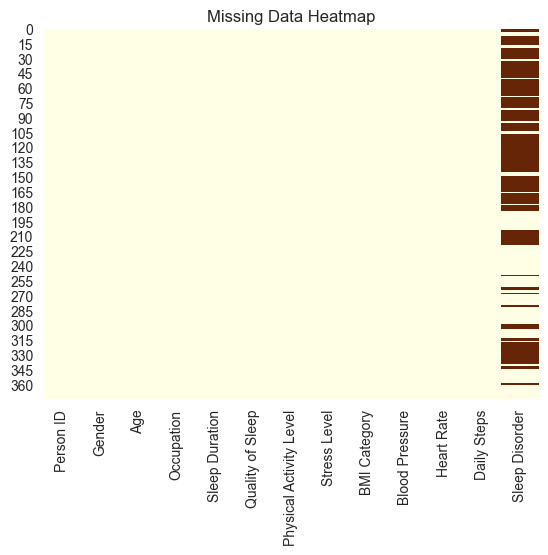

After dropna, shape: (155, 13)
   Gender  BMI Category  Sleep Disorder
0       1             2               1
1       1             2               1
2       1             2               0
3       1             2               0
4       0             1               1


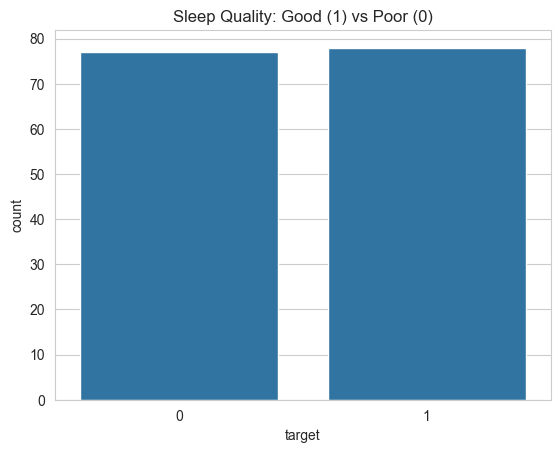

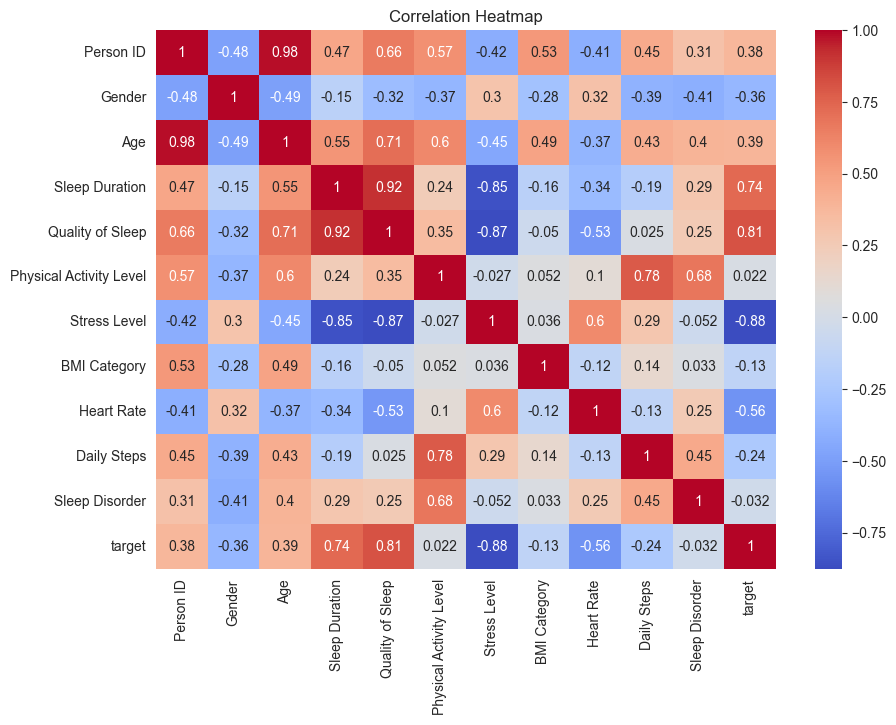

Train set: (124, 8), Test set: (31, 8)


In [1]:
# ===========================
# 1. Libraries, Data Loading, Cleaning
# ===========================

# 1.1 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# 1.2 Set notebook options for prettier display
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# 1.3 Load data
df = pd.read_csv('sleep_health_and_lifestyle.csv')  # CSV файл замаа тохируул
print(f"Dataset shape: {df.shape}")
display(df.head())

# 1.4 Check for missing data
print("\nMissing values per column:")
print(df.isnull().sum())
sns.heatmap(df.isnull(), cbar=False, cmap="YlOrBr")
plt.title("Missing Data Heatmap")
plt.show()

# 1.5 Drop rows with missing values (эсвэл дураараа fill хийж болно)
df = df.dropna().reset_index(drop=True)
print(f"After dropna, shape: {df.shape}")

# 1.6 Encode categorical variables
# Gender, BMI Category, Sleep Disorder-г тоогоор хувиргана
label_encoders = {}
for col in ['Gender', 'BMI Category', 'Sleep Disorder']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
print(df[['Gender', 'BMI Category', 'Sleep Disorder']].head())

# 1.7 Create target column (good=1, poor=0)
# Жишээ: Quality of Sleep >= 6.5 бол good
df['target'] = (df['Quality of Sleep'] >= 6.5).astype(int)
sns.countplot(x='target', data=df)
plt.title("Sleep Quality: Good (1) vs Poor (0)")
plt.show()

# 1.8 Correlation heatmap (numeric cols only)
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# 1.9 Feature/target сонгох
features = [
    'Age', 'Gender', 'Physical Activity Level', 'Stress Level',
    'Sleep Duration', 'Heart Rate', 'Daily Steps', 'Sleep Disorder'
]
X = df[features]
y = df['target']

# 1.10 Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1.11 Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

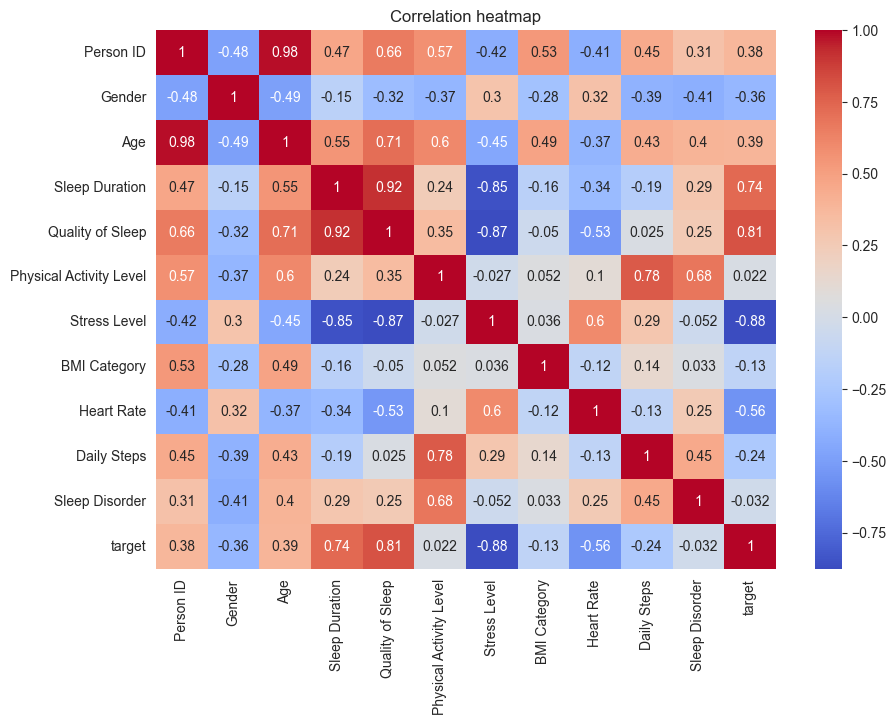

In [2]:

# 2. Correlation Heatmap
import seaborn as sns
import matplotlib.pyplot as plt
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()

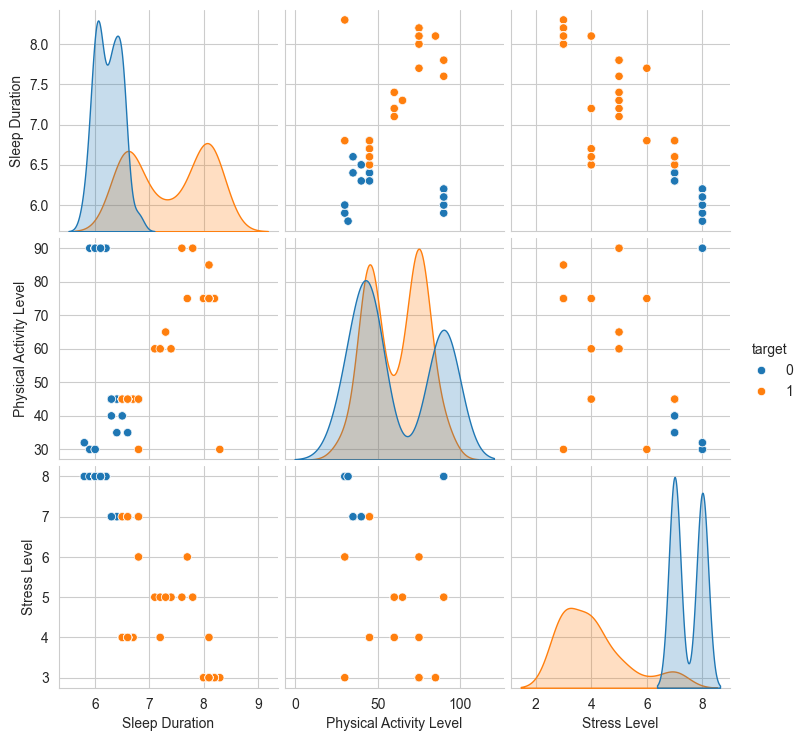

In [3]:

# 3. Pairplot (sleep duration vs. others)
sns.pairplot(df, hue='target', vars=['Sleep Duration', 'Physical Activity Level', 'Stress Level'])
plt.show()

In [4]:

# 4. Baseline: Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("LogReg accuracy:", logreg.score(X_test, y_test))

LogReg accuracy: 0.9354838709677419


In [5]:

# 5. Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Random Forest accuracy:", rf.score(X_test, y_test))

Random Forest accuracy: 0.967741935483871


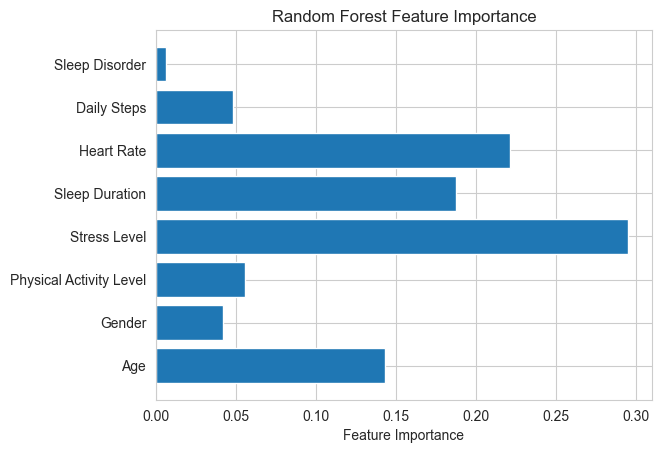

In [6]:

# 6. Feature importance (RF)
feat_importance = rf.feature_importances_
plt.barh(features, feat_importance)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

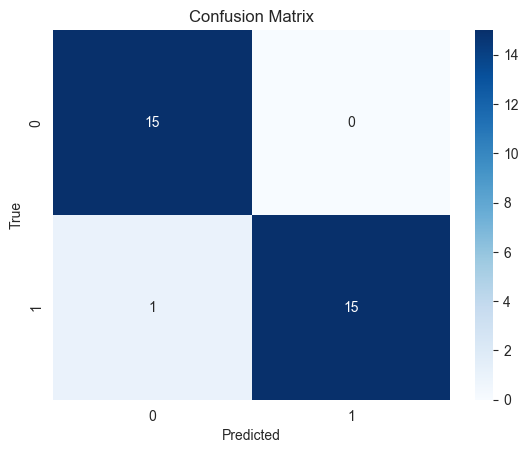

In [7]:

# 7. Confusion Matrix & ROC
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
y_pred_rf = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

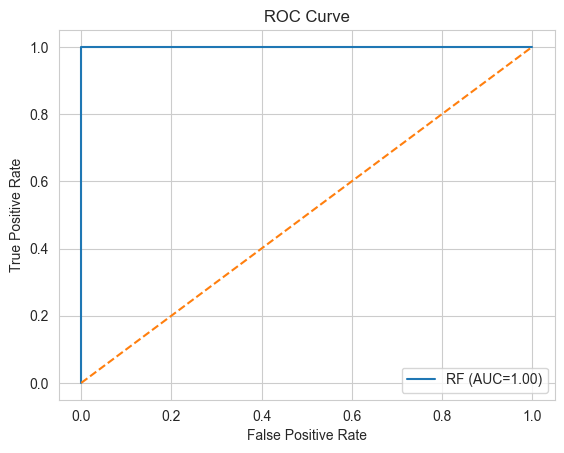

In [8]:

# ROC curve
from sklearn.metrics import roc_auc_score
y_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
plt.plot(fpr, tpr, label=f'RF (AUC={auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve'); plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

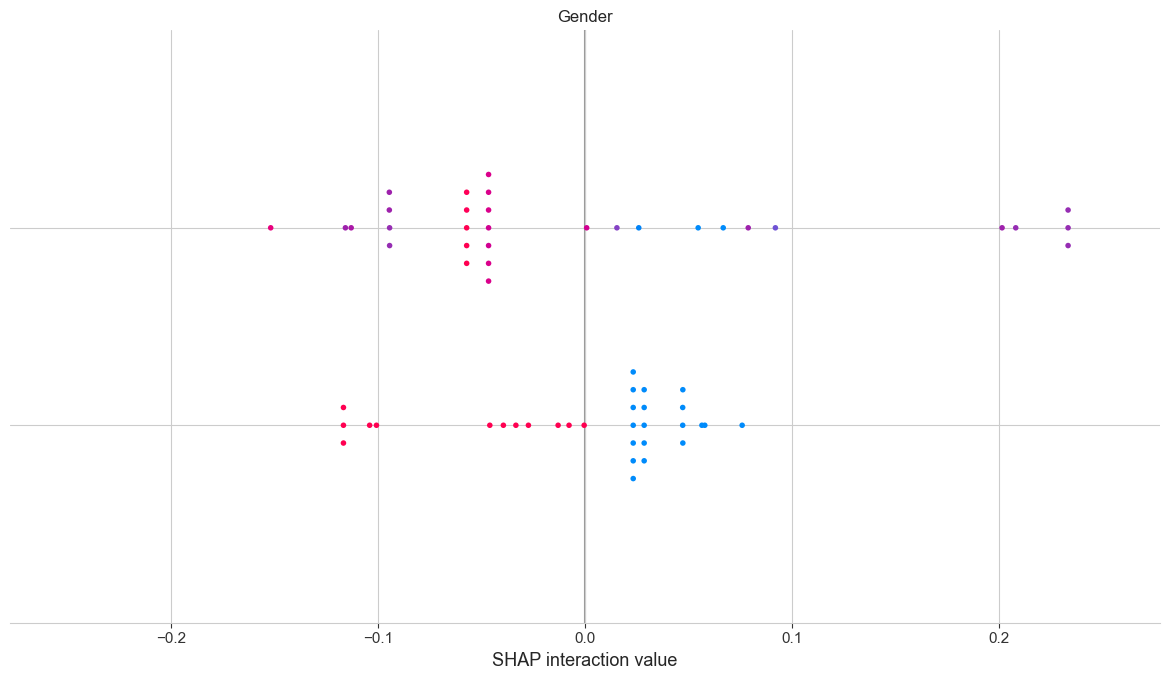

In [13]:

# 8. SHAP Explainability (bonus, very pro)
!pip install shap
import shap
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)

In [14]:

# 9. Model comparison table
from sklearn.metrics import accuracy_score, f1_score
models = {'Logistic Regression': logreg, 'Random Forest': rf}
for name, mdl in models.items():
    y_pred = mdl.predict(X_test)
    print(f"{name}: accuracy={accuracy_score(y_test, y_pred):.2f} f1={f1_score(y_test, y_pred):.2f}")

Logistic Regression: accuracy=0.94 f1=0.93
Random Forest: accuracy=0.97 f1=0.97


Epoch 1/30


/Users/shai/Desktop/lesson/Junior/AI/sleep_tensorflow/sleep-env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6767 - loss: 0.6560 - val_accuracy: 0.7419 - val_loss: 0.6047
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8248 - loss: 0.5850 - val_accuracy: 0.9355 - val_loss: 0.5515
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9660 - loss: 0.5310 - val_accuracy: 0.9355 - val_loss: 0.5064
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9555 - loss: 0.4916 - val_accuracy: 0.9355 - val_loss: 0.4662
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9337 - loss: 0.4608 - val_accuracy: 0.9355 - val_loss: 0.4279
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9629 - loss: 0.4054 - val_accuracy: 0.9355 - val_loss: 0.3895
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9504 - loss: 0.3691 - val_accuracy: 0.9355 - val_loss: 0.3515
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9599 - loss: 0.3388 - val_accuracy: 0.9355 - val_loss: 0.3155
Epoch 9/30
4/4 ━━━

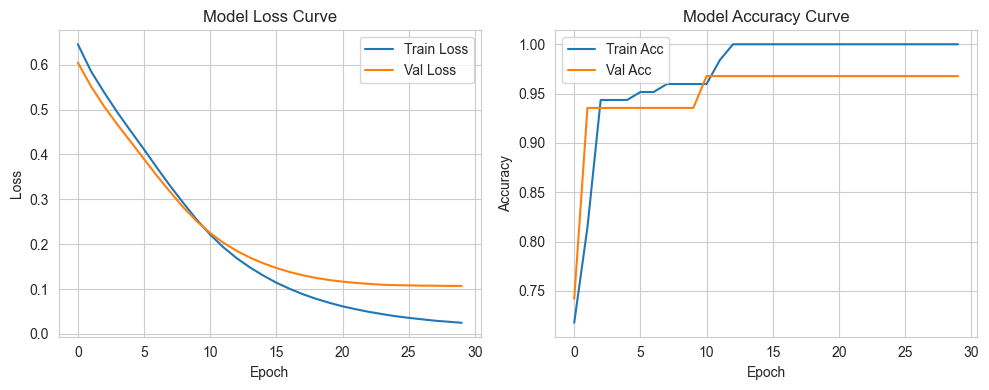

In [16]:
# 1. Train the model
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32
)

# 2. Loss болон accuracy-г plot хийх
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Curve')
plt.legend()

# Accuracy curve (classification model бол)
if 'accuracy' in history.history:
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Curve')
    plt.legend()

plt.tight_layout()
plt.show()
